# Homework part I: Prohibited Comment Classification (3 points)

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

## Load data

In [ ]:
import os

if not os.path.exists('comments.tsv'):
    !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring23/week06_nlp/comments.tsv

from IPython.display import clear_output
clear_output()

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('comments.tsv', sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values

data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [ ]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

## Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [ ]:
# task: preprocess each comment in train and test

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

In [ ]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

## Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [ ]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = 10000

from collections import Counter


counter = Counter()
for text in texts_train:
    counter.update(text.split())

bow_vocabulary = [word for word, _ in counter.most_common(k)]

print('example features:', sorted(bow_vocabulary)[::1000])

example features: ['!', 'came', 'faggot', 'lets', 'punctuation', 'theoretical']


In [ ]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    bow = np.zeros_like(bow_vocabulary, 'float32')
    for token in tokenizer.tokenize(text.lower()):
        if token in bow_vocabulary:
            idx = bow_vocabulary.index(token)
            bow[idx] += 1
    return bow

In [ ]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [ ]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Machine learning stuff: fit, predict, evaluate. You know the drill.

In [ ]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

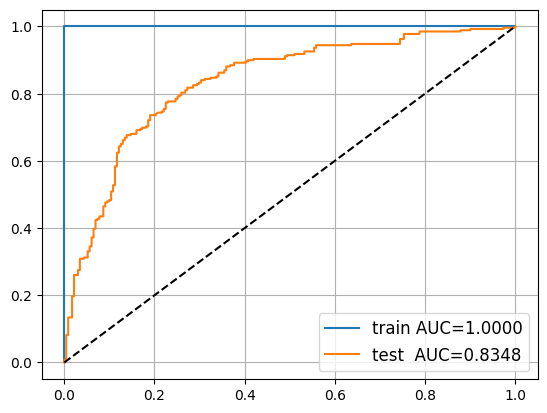

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

## Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
import gensim.downloader
embeddings = gensim.downloader.load('fasttext-wiki-news-subwords-300')
clear_output()

In [ ]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """

    def get_vector(token):
        if embeddings.has_index_for(token):
            return embeddings.get_vector(token)
        return np.zeros(embeddings.vectors.shape[1])

    features = np.stack(list(map(get_vector, comment.split()))).sum(axis=0)

    return features

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

In [ ]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

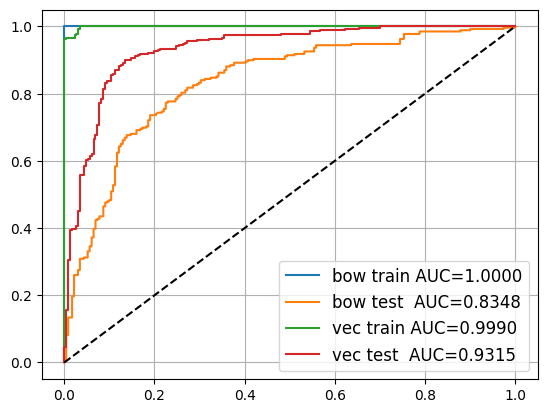

In [ ]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.

# Natural Language Processing with Deep Learning (7 points).

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

## About the challenge.
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).

In [ ]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
if not os.path.exists('Train_rev1.csv'):
    !pip install wldhx.yadisk-direct
    !curl -L $(yadisk-direct https://disk.yandex.ru/d/vVEOWPFY3NruT7) -o Train_rev1.zip
    !unzip Train_rev1.zip

from IPython.display import clear_output
clear_output()

In [ ]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
156499,71094747,Community Nurse Redhill,NHS experienced nurses required for a communit...,Redhill,Redhill,full_time,NaN,Team 24 Ltd,Healthcare & Nursing Jobs,"28,000 - 32,000/Year",30000,staffnurse.com,10.308986
235567,72546352,1st/2nd Line Support / Networking / Windows Se...,Junior 2nd Line Support Engineer / 3 Month Con...,"East London, London",East London,NaN,contract,Capita Resourcing,IT Jobs,90 - 95/day,22200,cv-library.co.uk,10.007893
47300,68574619,Health & Social Care NVQ/QCF Assessor,Alderwood are representing a national training...,West Sussex - Horsham,Horsham,full_time,permanent,UKStaffsearch,HR & Recruitment Jobs,18000 - 24000,21000,ukstaffsearch.com,9.952325


## The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [ ]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [ ]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(str(text).lower()))

for col in text_columns:
    data[col] = data[col].apply(preprocess)

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()

for _, (title, description) in data[text_columns].iterrows():
    token_counts.update(title.split())
    token_counts.update(description.split())

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


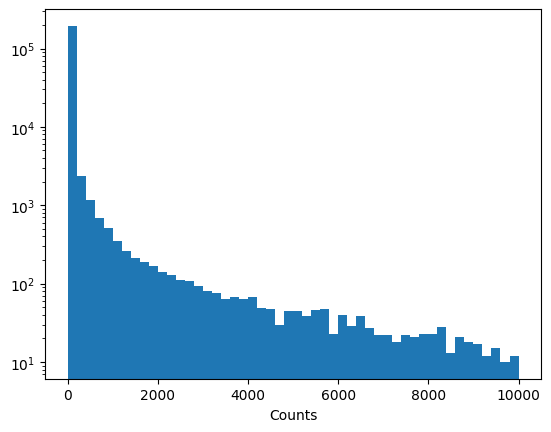

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = list(filter(lambda x: token_counts.get(x) >= min_count, token_counts))

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_to_id = dict(zip(tokens, range(len(tokens))))

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

## The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [ ]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)

    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)

    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch

## Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]

device = torch.device('cuda')

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ A simple sequential encoder for titles: x -> emb -> conv -> global_max -> relu -> dense """
        super(self.__class__, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings=n_tokens, embedding_dim=128, padding_idx=PAD_IX)
        self.conv = nn.Sequential(nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1), GlobalMaxPooling())

        self.dense1 = nn.Sequential(
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
        )

        self.dense2 = nn.Sequential(
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=out_size),
        )

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        # create embeddings
        h = self.embeddings(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = self.conv(torch.transpose(h, 1, 2))

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.dense2(self.dense1(h))

        return h

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [ ]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ A simple sequential encoder for titles: x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings=n_tokens, embedding_dim=256, padding_idx=PAD_IX)
        self.conv = nn.Sequential(nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1), GlobalMaxPooling())

        self.dense1 = nn.Sequential(
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
        )

        self.dense2 = nn.Sequential(
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
        )

        self.dense3 = nn.Sequential(
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=out_size),
        )

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        # create embeddings
        h = self.embeddings(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = self.conv(torch.transpose(h, 1, 2))

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.dense3(self.dense2(self.dense1(h)))

        return h

In [ ]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=128)

        # define layers for categorical features. A few dense layers would do.
        self.categorical_dense = nn.Sequential(
            nn.Linear(in_features=3768, out_features=512),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=64),
        )

        # define "output" layers that process depend the three encoded vectors into answer
        self.dense = nn.Sequential(
            nn.Linear(in_features=64 + 128 + 64, out_features=64),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )

    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """

        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        # apply categorical encoder
        cat_h = self.categorical_dense(cat_features)

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top
        x = self.dense(joint_h).flatten()

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

In [ ]:
from tqdm.notebook import trange

def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]

    irange = trange if verbose else range

    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

## Let's train it!


In [ ]:
num_epochs = 30
max_len = 100
batch_size = 32
batches_per_epoch = 500

In [ ]:
patiance = 0
scores = []

for epoch_i in range(num_epochs):

    print("Training:")
    train_loss = train_mae = train_batches = 0
    model.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.detach().cpu().numpy()
        train_mae += compute_mae(reference, prediction).data.detach().cpu().numpy()
        train_batches += 1

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')

    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.detach().cpu().numpy()
            val_mae += compute_mae(reference, prediction).data.detach().cpu().numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

    scores.append(val_mae / val_batches)

    if scores[-1] > min(scores):
        patiance += 1

    if scores[-1] == min(scores):
        torch.save(model.state_dict(), 'simple_model.pt')

    if patiance == 10:
        break

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	26.13637
	MAE:	12897.99633



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.10471
	MAE:	7881.06248



Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	0.46792
	MAE:	7400.61449



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.43806
	MAE:	5817.54863



Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	0.24386
	MAE:	4750.25922



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17278
	MAE:	3838.30954



Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	0.19462
	MAE:	4252.91782



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.50281
	MAE:	6146.52503



Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	0.17728
	MAE:	3986.05008



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10705
	MAE:	3102.08831



Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	0.16242
	MAE:	3895.42972



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.48937
	MAE:	5890.41574



Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	0.13687
	MAE:	3571.85991



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12292
	MAE:	3269.96508



Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	0.12878
	MAE:	3475.37378



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12933
	MAE:	3376.53090



Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	0.13656
	MAE:	3523.67132



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17939
	MAE:	3802.88722



Training:


  0%|          | 0/500 [00:00<?, ?it/s]

	Loss:	0.12115
	MAE:	3353.26200



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16256
	MAE:	3722.24961





In [ ]:
model.load_state_dict(torch.load('simple_model.pt'))

print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.detach().cpu().numpy()
        val_mae += compute_mae(reference, prediction).data.detach().cpu().numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10705
	MAE:	3102.08831





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order,
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

# Solution

We will build a model:
1. Use `word2vec-google-news-300` embedding for title and description [C].
2. We will mix convolutions and recurrent (RNN) layers differently for title and description [A, D].
3. Change Max-Pooling Algo [B].

Also we will save version with the best score (+early stopping)



In [ ]:
import gensim.downloader
embeddings = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
UNK, PAD = 'UNK', 'PAD'

tokens = embeddings.index_to_key.copy()
tokens = tokens

token_to_id = dict(zip(tokens, range(len(tokens))))

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[  2673    921   1765  35636  35636]
 [ 41053   1911  35636  35636  35636]
 [   567 207291    287   4501   4982]]


In [ ]:
class GlobalAveragePooling(nn.Module):
    def __init__(self, dim=-1):
        super(GlobalAveragePooling, self).__init__()
        self.dim = dim

    def forward(self, x):
        """x: [batch, sequence_length, embedding_dim]"""
        return x.mean(dim=self.dim)

In [ ]:
class SoftmaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(SoftmaxPooling, self).__init__()
        self.dim = dim

    def forward(self, x):
        """x: [batch, sequence_length, embedding_dim]"""
        x = x.softmax(dim=self.dim) * x
        return x.sum(dim=self.dim)

In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(self.__class__, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=4, batch_first=True, bidirectional=True)
        self.dense = nn.Sequential(
            nn.BatchNorm1d(num_features=hidden_size * 2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size * 2, out_features=out_size),
        )

    def forward(self, embeddings):
        # [batch_size, sequence_length, embedding_dim] -> [batch_size, sequence_length, hidden_size * 2]
        outputs, _ = self.rnn(embeddings)

        # [batch_size, sequence_length, hidden_size * 2] -> [batch_size, hidden_size * 2]
        outputs = outputs.sum(dim=1)

        # [batch_size, hidden_size * 2] -> [batch_size, out_size]
        outputs = self.dense(outputs)

        return outputs

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, pooling):
        super(self.__class__, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, padding=1),
            pooling,
        )
        self.dense = nn.Sequential(
            nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=out_size),
        )

    def forward(self, embeddings):

        # [batch_size, embedding_dim, sequence_length] -> [batch_size, hidden_size, sequence_length] -> [batch_size, hidden_size]
        outputs = self.conv(torch.transpose(embeddings, 1, 2))

        # [batch_size, hidden_size] -> [batch_size, out_size]
        outputs = self.dense(outputs)

        return outputs

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, out_size=64):
        super(self.__class__, self).__init__()

        self.conv1 = CNNEncoder(input_size=300, hidden_size=128, out_size=128, pooling=GlobalMaxPooling())
        self.conv2 = CNNEncoder(input_size=300, hidden_size=128, out_size=128, pooling=GlobalAveragePooling())
        self.conv3 = CNNEncoder(input_size=300, hidden_size=128, out_size=128, pooling=SoftmaxPooling())

        self.dense = nn.Sequential(
            nn.BatchNorm1d(num_features=128 * 3),
            nn.ReLU(),
            nn.Linear(in_features=128 * 3, out_features=out_size),
        )

    def forward(self, embeddings):
        outputs = torch.cat([self.conv1(embeddings), self.conv2(embeddings), self.conv3(embeddings)], dim=1)
        outputs = self.dense(outputs)

        return outputs


class DescEncoder(nn.Module):
    def __init__(self, out_size=128):
        super(self.__class__, self).__init__()

        self.rnn   = RNNEncoder(input_size=300, hidden_size=512, out_size=128)

        self.dense = nn.Sequential(
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=out_size),
        )

    def forward(self, embeddings):
        outputs = self.rnn(embeddings)
        outputs = self.dense(outputs)

        return outputs

In [ ]:
class FullNetwork(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(embeddings.vectors, dtype=torch.float32), padding_idx=PAD_IX)

        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder(out_size=128)

        # define layers for categorical features. A few dense layers would do.
        self.categorical_dense = nn.Sequential(
            nn.Linear(in_features=3768, out_features=512),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=64),
        )

        # define "output" layers that process depend the three encoded vectors into answer
        self.dense = nn.Sequential(
            nn.Linear(in_features=64 * 4, out_features=64),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )

    def forward(self, title_ix, desc_ix, cat_features):

        # [batch_size, sequence_length] -> [batch_size, sequence_length, embedding_dim]
        embeddings_title = self.embeddings(title_ix)
        embeddings_desc  = self.embeddings(desc_ix)

        # process each data source with it's respective encoder
        title_h = self.title_encoder(embeddings_title)
        desc_h = self.desc_encoder(embeddings_desc)

        # apply categorical encoder
        cat_h = F.relu(self.categorical_dense(cat_features))

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top
        x = self.dense(joint_h).flatten()

        return x

In [ ]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
num_epochs = 16
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
patiance = 0
scores = []

for epoch_i in range(num_epochs):

    print("Training:")
    train_loss = train_mae = train_batches = 0
    model.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.detach().cpu().numpy()
        train_mae += compute_mae(reference, prediction).data.detach().cpu().numpy()
        train_batches += 1

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')

    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.detach().cpu().numpy()
            val_mae += compute_mae(reference, prediction).data.detach().cpu().numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

    scores.append(val_mae / val_batches)

    if scores[-1] > min(scores):
        patiance += 1

    if scores[-1] == min(scores):
        torch.save(model.state_dict(), 'large_model.pt')

    if patiance == 5:
        break

Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	64.97072
	MAE:	12549.90243



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	55.71945
	MAE:	12513.74333



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	18.74042
	MAE:	12131.03484



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	7.98883
	MAE:	11492.91003



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.73961
	MAE:	9290.30908



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.56117
	MAE:	8175.64251



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.69873
	MAE:	7917.62712



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.45398
	MAE:	5081.17350



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.43616
	MAE:	6643.84758



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.34681
	MAE:	4951.65246



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.37722
	MAE:	6241.21975



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.59057
	MAE:	5724.37949



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.32776
	MAE:	5793.66012



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.29652
	MAE:	4542.60621



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.28747
	MAE:	5295.38825



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.41257
	MAE:	5254.29297



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.25443
	MAE:	5051.75143



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.28753
	MAE:	4706.45920



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.25232
	MAE:	5017.95044



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load('large_model.pt'))

print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.detach().cpu().numpy()
        val_mae += compute_mae(reference, prediction).data.detach().cpu().numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

1. Попробовал все варианты
2. Не получилось сделать Attentive Pooling
3. Не удалось покрутить параметры (качество сложной модели хуже простой - возможно из-за параметров, возможно недообучился)

Пробовал различные комибнации CNN и RNN для заголовков и описаний вакансий.